---
title: VGG Paper Implementation from Scratch
author: Aras Edeş
date: '2023-06-29'
categories:
  - IN PROGRESS
  - Deep Learning
  - PyTorch
  - VGG
image: vgg16.png
execute: 
  enabled: false
editor:
  render-on-save: true
---

<a target="_blank" href="https://colab.research.google.com/github/Ar-Ed/blog/blob/main/posts/vgg/index.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction
In this article I will be guiding you through the implementation of [VGG paper](https://arxiv.org/abs/1409.1556). VGG paper is published in 2015. Title of the paper is "Very Deep Convolutional Networks for Large-Scale Image Recognition". I agree, quite a mouthful but the proposed models managed to place second place in Classification and first place in Localization for ImageNet 2014 Challange. Mainly, authors investigate the following:

1. Use of deeper networks (Convolutional that is)
2. Small filter sizes (3x3 and 1x1)
3. Systematically decreasing feature size and increasing filter count

Architectures presented in the paper consist of Conv, MaxPool, Fully-Connected layers and ReLU activation (apart from softmax for multi-class classification). Nowadays, BatchNorm is in wide use but it wasn't on the map at the time of this paper (although one of the architectures utilized LocalResponseNormalization but it is reported to have no benefit). Similarly Dropout layers are not used as well. Layer configurations can be summarized as:

1. ReLU Activation after every parametrized layer
2. MaxPool layers (2x2) window with stride 2
3. Common fully-connected layers accross the proposed architectures
4. Convolutional layers with (3x3) and (1x1) filters with "same" padding. Filter count ranges from 64 to 512 and incremented by doubling

| A         | A-LRN     | B         | C         | D         | E         |
|-----------|-----------|-----------|-----------|-----------|-----------|
| 11 layers | 11 layers | 13 layers | 16 layers | 16 layers | 19 layers |
| conv3-64  | conv3-64  | conv3-64  | conv3-64  | conv3-64  | conv3-64  |
|           | LRN       | conv3-64  | conv3-64  | conv3-64  | conv3-64  |
| maxpool   | maxpool   | maxpool   | maxpool   | maxpool   | maxpool   |
| conv3-128 | conv3-128 | conv3-128 | conv3-128 | conv3-128 | conv3-128 |
|           |           | conv3-128 | conv3-128 | conv3-128 | conv3-128 |
| maxpool   | maxpool   | maxpool   | maxpool   | maxpool   | maxpool   |
| conv3-256 | conv3-256 | conv3-256 | conv3-256 | conv3-256 | conv3-256 |
| conv3-256 | conv3-256 | conv3-256 | conv3-256 | conv3-256 | conv3-256 |
|           |           |           | conv1-256 | conv3-256 | conv3-256 |
|           |           |           |           |           | conv3-256 |
| maxpool   | maxpool   | maxpool   | maxpool   | maxpool   | maxpool   |
| conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 |
| conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 |
|           |           |           | conv1-512 | conv3-512 | conv3-512 |
|           |           |           |           |           | conv3-512 |
| maxpool   | maxpool   | maxpool   | maxpool   | maxpool   | maxpool   |
| conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 |
| conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 | conv3-512 |
|           |           |           | conv1-512 | conv3-512 | conv3-512 |
|           |           |           |           |           | conv3-512 |
| maxpool   | maxpool   | maxpool   | maxpool   | maxpool   | maxpool   |
| FC-4096   | FC-4096   | FC-4096   | FC-4096   | FC-4096   | FC-4096   |
| FC-4096   | FC-4096   | FC-4096   | FC-4096   | FC-4096   | FC-4096   |
| FC-1000   | FC-1000   | FC-1000   | FC-1000   | FC-1000   | FC-1000   |
| soft-max  | soft-max  | soft-max  | soft-max  | soft-max  | soft-max  |

: Architecture Summary

# Implementation

In this tutorial I will be usign PyTorch. It is a flexible library for deep learning and tensor operations (like numpy) for gpu and cpu. "nn" module is a framework for defining neural networks with predefined layers (so we don't have to write our Conv Layer for example). I will be using the **Caltech256** dataset from the torchvision datasets module. Dataloader wraps an iterable around the dataset so that it would be easier to train.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

import PIL
import matplotlib.pyplot as plt
import numpy as np

import os
import glob
from collections import OrderedDict

By instantiating Caltech256, Caltech256 Dataset will be downloaded unzipped and loaded with [PIL](https://pillow.readthedocs.io/en/stable/) library. ToTensor transforms theses PIL Images to Torch Tensors.  

In [2]:
# Caltech256 has both RGB and Grayscale images
def gray_to_rgb(image: PIL.Image):
    return image.convert("RGB")

dataset = datasets.Caltech256("data/",
                                download=True,
                                transform=transforms.Compose([
                                    gray_to_rgb,
                                    transforms.ToTensor(),
                                    transforms.Resize((224, 224), antialias=False),
                                ]))
dataloader = DataLoader(dataset,
                        batch_size=16,
                        shuffle=True)

Files already downloaded and verified


In [3]:
label_to_category = list(enumerate([os.path.basename(os.path.normpath(dir).split(".")[1]) 
 for dir in glob.glob("data/caltech256/256_ObjectCategories/*/")]))

def map_label_to_category(label):
    return label_to_category[label][1]

map_label_to_category(1)

'american-flag'

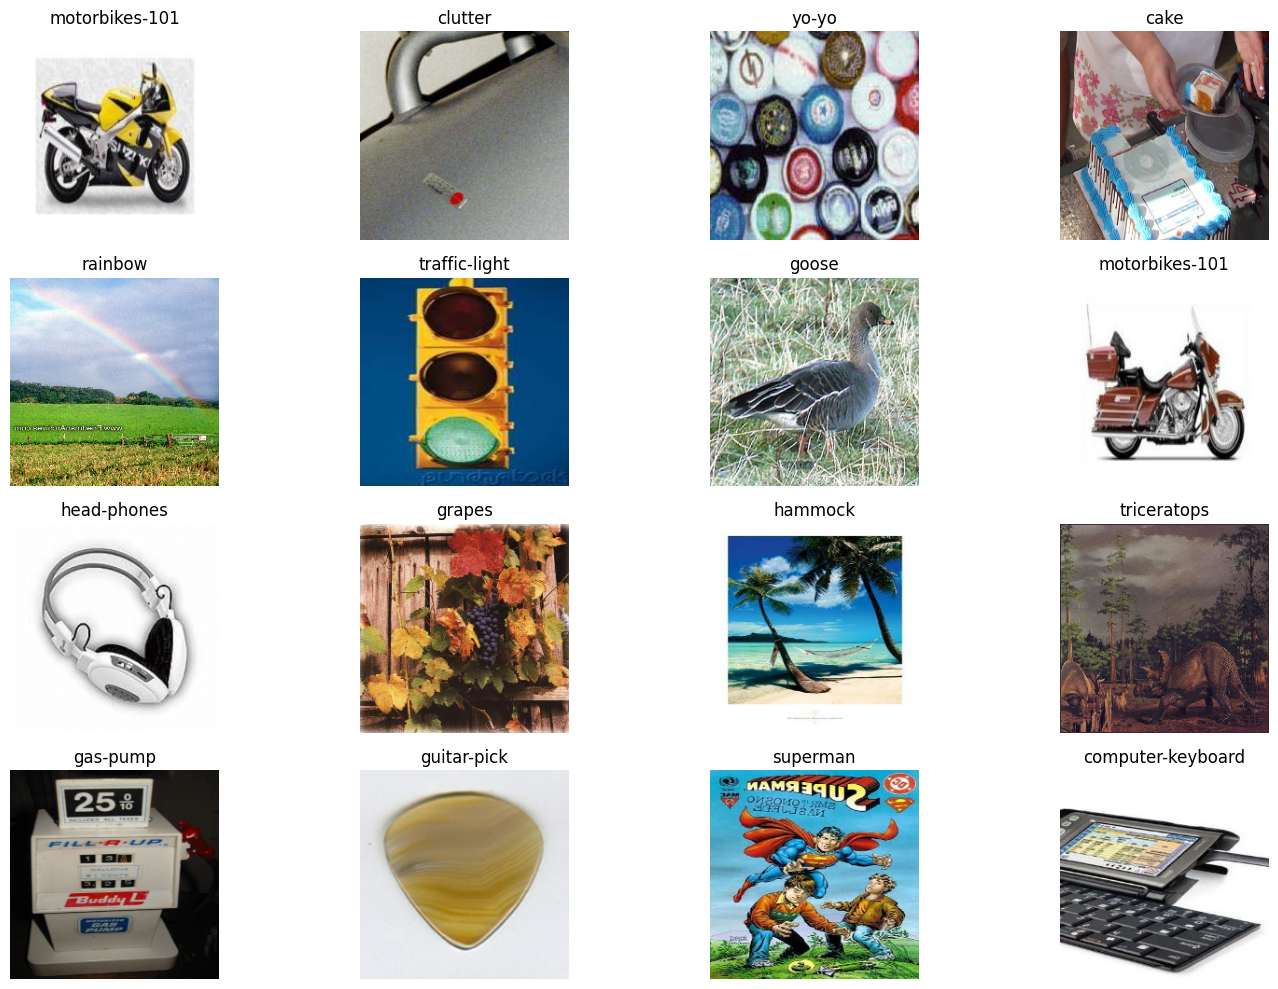

In [5]:
batch = next(iter(dataloader))

plt.figure(figsize=(15, 10))
for index, (images, labels) in enumerate(zip(batch[0], batch[1])):
    plt.subplot(4, 4, index + 1)
    plt.imshow(images.permute(1, 2, 0), )
    plt.title(map_label_to_category(labels.item()))
    plt.axis("off")
plt.tight_layout()
plt.show()

Now that we have out dataset ready, let's start implementing the paper 

In [6]:
# Inherit from nn.Module for compatibility with the nn API
class VGG(nn.Module):

    # define architecture parameters 
    # tuple -> Conv2d(in_channels, out_channels, kernel_size)
    conv_architectures = dict(
        A=[(3, 64, 3), "max", (64, 128, 3), "max", (128, 256, 3), (256, 256, 3), "max", (256, 512, 3), (512, 512, 3), "max", (512, 512, 3), (512, 512, 3), "max"],
        A_LRN=[(3, 64, 3), "lrn", "max", (64, 128, 3), "max", (128, 256, 3), (256, 256, 3), "max", (256, 512, 3), (512, 512, 3), "max", (512, 512, 3), (512, 512, 3), "max"],
        B=[(3, 64, 3), (64, 64, 3), "max", (64, 128, 3), (128, 128, 3), "max", (128, 256, 3), (256, 256, 3), "max", (256, 512, 3), (512, 512, 3), "max", (512, 512, 3), (512, 512, 3), "max"],
        C=[(3, 64, 3), (64, 64, 3), "max", (64, 128, 3), (128, 128, 3), "max", (128, 256, 3), (256, 256, 3), (256, 256, 1), "max", (256, 512, 3), (512, 512, 3), (512, 512, 1), "max", (512, 512, 3), (512, 512, 3), (512, 512, 1), "max"],
        D=[(3, 64, 3), (64, 64, 3), "max", (64, 128, 3), (128, 128, 3), "max", (128, 256, 3), (256, 256, 3), (256, 256, 3), "max", (256, 512, 3), (512, 512, 3), (512, 512, 3), "max", (512, 512, 3), (512, 512, 3), (512, 512, 3), "max"],
        E=[(3, 64, 3), (64, 64, 3), "max", (64, 128, 3), (128, 128, 3), "max", (128, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), "max", (256, 512, 3), (512, 512, 3), (512, 512, 3), (512, 512, 3), "max", (512, 512, 3), (512, 512, 3), (512, 512, 3), (512, 512, 3), "max"],
    )

    def __init__(self, architecture_identifier="A", batch_norm=False):
        super().__init__()
        self.fully_connected = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1000)
        )

        self.conv_architecture = self.conv_architectures[architecture_identifier]
        self.conv_layers = nn.Sequential()
        
        for options in self.conv_architecture:
            if isinstance(options, tuple):
                self.conv_layers.append(nn.Conv2d(*options, padding="same", stride=1))
                self.conv_layers.append(nn.ReLU())
            elif options == "lrn":
                self.conv_layers.append(nn.LocalResponseNorm(5, alpha=1e-4, beta=0.75, k=2))
            elif options == "max":
                self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        
        self.model = nn.Sequential(OrderedDict([
            ("feature_extractor", self.conv_layers),
            ("classifier", self.fully_connected)
        ]))

    def forward(self, input):
        return self.model(input)
    

Let's take a look at model A with LocalResponseNormalization:

In [7]:
VGG("A_LRN").model

c:\Users\edesa\Desktop\ML Research\env\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17)

# Training

In [22]:
batch_size = 256
momentum = 0.9
weight_decay = 5e-4

In [21]:
dataset = datasets.Caltech256("data/",
                                download=True,
                                transform=transforms.Compose([
                                    gray_to_rgb,
                                    transforms.ToTensor(),
                                    transforms.Resize((512, 512), antialias=False),
                                    transforms.RandomCrop(size=(224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                    ),
                                ]))
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True)

Files already downloaded and verified


![After Image Augmentation](transformed.png)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(momentum=momentum, weight_decay=weight_decay)

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# Conclusion